<a href="https://colab.research.google.com/github/teoad95/Deep-learning-Cryptocurrency-price-prediction/blob/main/Classification_using_crypto_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [35]:
eth_market_info = pd.read_csv('ETH-USD.csv')

In [36]:
eth_market_info = eth_market_info.dropna(how='any',axis=0) 
eth_market_info['Date'] = pd.to_datetime(eth_market_info['Date'])
eth_market_info.loc[eth_market_info['Volume']=="-",'Volume']=0
eth_market_info.columns = eth_market_info.columns.str.replace("*", "")

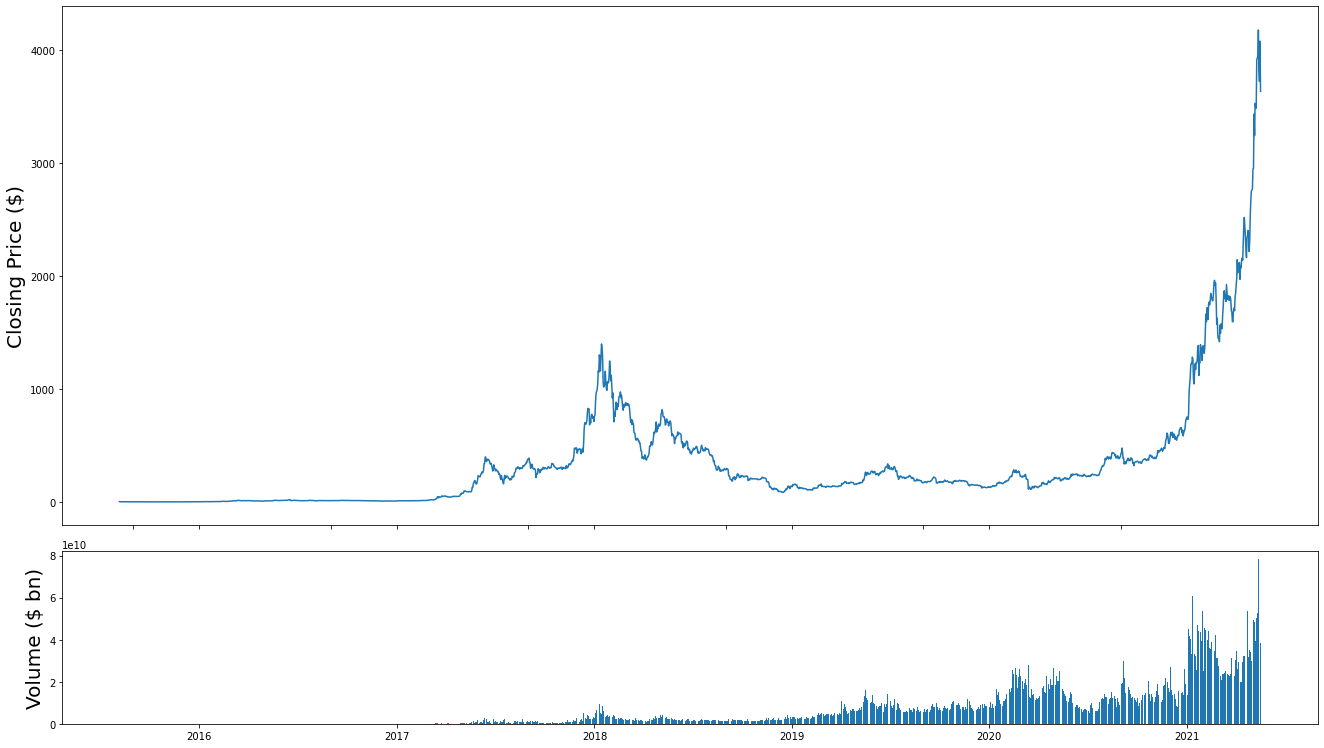

In [37]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
ax1.set_ylabel('Closing Price ($)',fontsize=20)
ax2.set_ylabel('Volume ($ bn)',fontsize=20)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,9]])
ax1.set_xticklabels('')
ax1.plot(eth_market_info['Date'],eth_market_info['Open'])
ax2.bar(eth_market_info['Date'], eth_market_info['Volume'].values)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
plt.show()

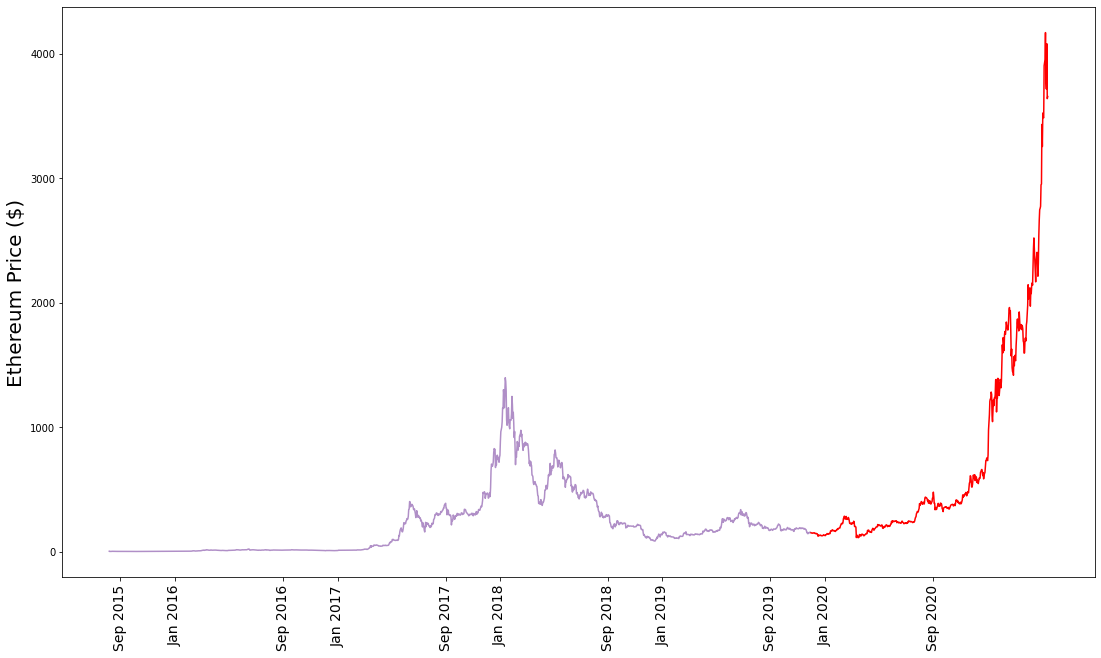

In [38]:
split_date = '2019-12-01'
fig, (ax2) = plt.subplots(1,1)
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,9]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,9]])
ax2.plot(eth_market_info[eth_market_info['Date'] < split_date]['Date'],
         eth_market_info[eth_market_info['Date'] < split_date]['Close'], 
         color='#B08FC7')
ax2.plot(eth_market_info[eth_market_info['Date'] >= split_date]['Date'],
         eth_market_info[eth_market_info['Date'] >= split_date]['Close'], color='red')
ax2.set_ylabel('Ethereum Price ($)',fontsize=20)
fig.set_size_inches(18.5, 10.5)
plt.xticks(fontsize=14, rotation=90)
plt.show()

In [39]:
window_len = 10

In [40]:
kwargs = {'day_diff': lambda x: (x['Close']-x['Open'])/x['Open'],
          'volatility': lambda x: (x['High']- x['Low'])/(x['Open'])}
eth_market_info = eth_market_info.assign(**kwargs)
eth_market_info['NewColumn'] = eth_market_info['Close'] - eth_market_info['Close'].shift(window_len - 1)
eth_market_info.insert(0, 'Y', eth_market_info['NewColumn'] > 0)
eth_market_info = eth_market_info.drop(['NewColumn'], axis=1)
eth_market_info = eth_market_info.sort_values(by='Date')

In [41]:
model_data = eth_market_info.sort_values(by='Date')
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [45]:
test_set_to_predict_value

0       True
1      False
2       True
3       True
4       True
       ...  
524     True
525     True
526     True
527     True
528     True
Name: Y, Length: 529, dtype: bool

In [43]:
test_set_to_predict_value = test_set['Y'].reset_index(drop=True)
test_set = test_set.drop(['Y'], axis=1)
training_set_to_predict_value = training_set['Y'].reset_index(drop=True)
training_set = training_set.drop(['Y'], axis=1)

In [46]:
from sklearn.preprocessing import MinMaxScaler
# define min max scaler
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

In [47]:
x_train = []
y_train = []

In [48]:
for i in range(window_len, training_set.shape[0]):
    x_train.append(training_set[i-window_len:i])
    y_train.append(float(training_set_to_predict_value[i]))

In [49]:
x_test = []
y_test = []

In [50]:
for i in range(window_len, test_set.shape[0]):
    x_test.append(test_set[i-window_len:i])
    y_test.append(float(test_set_to_predict_value[i]))

In [51]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

In [68]:
sum_true = 0
sum_false = 0
for i in range(0, len(y_train)):
    if (y_train[i] >= 0.5):
      sum_true += 1
    else:
      sum_false += 1

print(f'In train dataset we have {str(sum_true)} increases and {str(sum_false)} decreases.')

In train dataset we have 836 increases and 731 decreases.


In [69]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [59]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow_addons as tfa

def build_model2():
    model = Sequential()

    model.add(LSTM(units = 50, activation = 'relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(units=64))
    model.add(Dense(units=1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [106]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
import tensorflow_addons as tfa
from keras.optimizers import SGD

def build_model3():
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dense(units=1))
    my_GRU_model.compile(optimizer='adam',loss='binary_crossentropy')
    return my_GRU_model

In [107]:
model = build_model3()
history = model.fit(x_train, y_train, epochs = 50, batch_size = 64, validation_split = 0.3, callbacks=[early_stopping])

Epoch 1/50
18/18 [==============================] - 6s 83ms/step - loss: 8.7513 - val_loss: 7.5651
Epoch 2/50
18/18 [==============================] - 0s 18ms/step - loss: 8.9797 - val_loss: 7.5651
Epoch 3/50
18/18 [==============================] - 0s 18ms/step - loss: 8.6346 - val_loss: 7.5651
Epoch 4/50
18/18 [==============================] - 0s 19ms/step - loss: 8.6046 - val_loss: 7.5651
Epoch 5/50
18/18 [==============================] - 0s 19ms/step - loss: 8.4888 - val_loss: 7.5651
Epoch 6/50
18/18 [==============================] - 0s 20ms/step - loss: 8.5459 - val_loss: 7.5651
Epoch 7/50
18/18 [==============================] - 0s 20ms/step - loss: 8.4325 - val_loss: 7.5651
Epoch 8/50
18/18 [==============================] - 0s 18ms/step - loss: 8.6091 - val_loss: 7.5651
Epoch 9/50
18/18 [==============================] - 0s 19ms/step - loss: 8.3784 - val_loss: 7.5651
Epoch 10/50
18/18 [==============================] - 0s 19ms/step - loss: 8.5113 - val_loss: 7.5651
Epoch 11/

In [102]:
np.random.seed(202)
model = build_model2()
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs = 50, batch_size = 64, validation_split = 0.3, callbacks=[early_stopping])

Epoch 1/50


KeyboardInterrupt: ignored

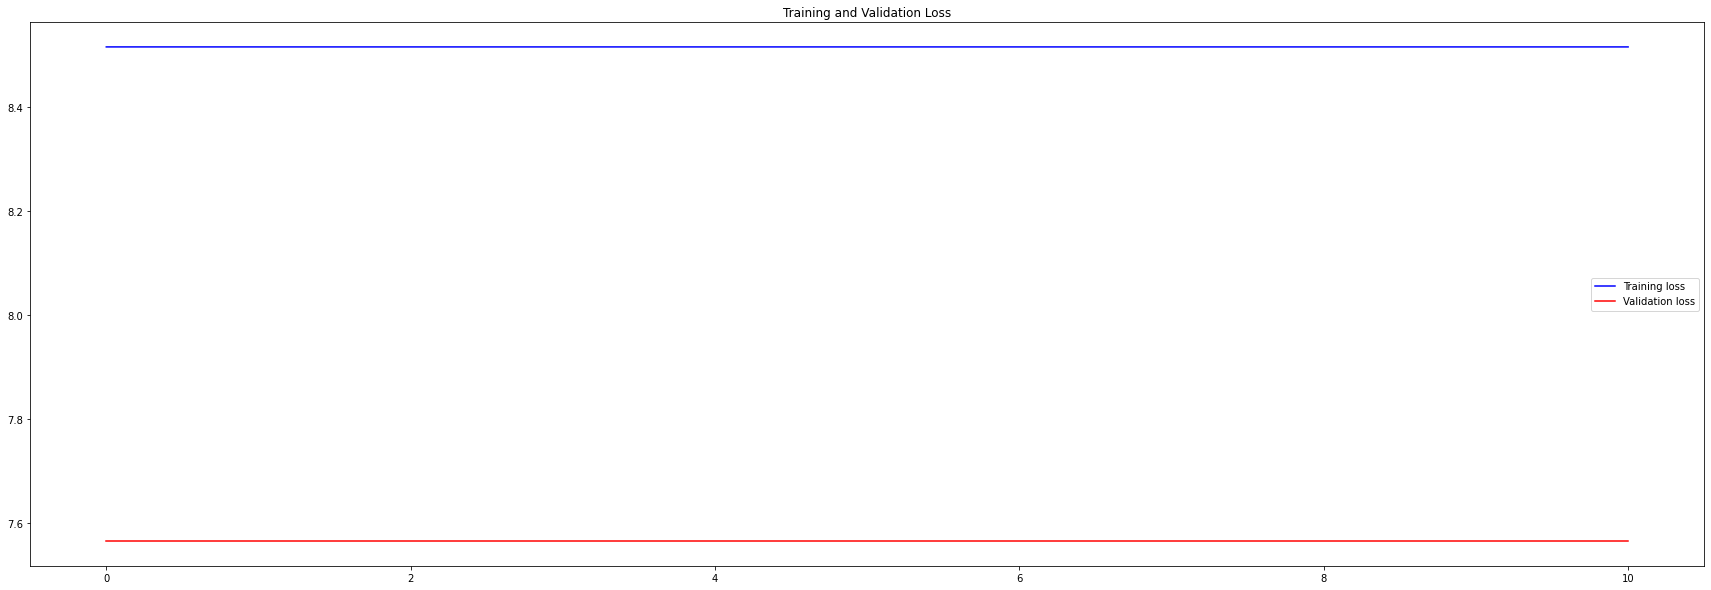

In [108]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(30,10))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [96]:
def round_predictions(y_pred):
  for i in range(0, len(y_pred)):
    pred = 0
    if (y_pred[i] >= 0.5):
      pred = 1
    y_pred_rounded.append(pred)
  return y_pred_rounded

In [110]:
def ShowMetrics(model, actual, predictions): 
    print('Model used summary:')
    model.summary()
    print()
    print()
    print()
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import f1_score
    import pandas as pd
    label_names = ['Decreased', 'Increased']
    cmx = confusion_matrix(actual, predictions)
    df = pd.DataFrame(cmx, columns=label_names, index=label_names)
    df.columns.name = 'prediction'
    df.index.name = 'label'
    print(df)
    print('f1 score::' + str(f1_score(actual, predictions)))

In [109]:
y_pred = model.predict(x_test)
y_pred_rounded = []
y_pred_rounded = round_predictions(y_pred)

In [75]:
ShowMetrics(model, y_test, y_pred_rounded)

Model used summary:
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20)                2320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 2,341
Trainable params: 2,341
Non-trainable params: 0
_________________________________________________________________



prediction  Decreased  Increased
label                           
Decreased          11        160
Increased           4        344
f1 score::0.8075117370892018
